<div style="background:#FFFFAA">
<img src="./logo.jpg", width=150, ALIGN="left", border=20>
<h1>L2RPN Starting Kit </h1> 

<br>This code was tested with <br>
Python 3.6.6 |Anaconda custom (64-bit)| (default, Nov 2018, 11:07:29) (https://anaconda.org/)<br>
<i> Adapted for Chalab by Isabelle Guyon from original code of Balázs Kégl</i> <br>
<a href="http://www.datascience-paris-saclay.fr">Paris Saclay Center for Data Science (CDS)</a>
</center>
<p>
ALL INFORMATION, SOFTWARE, DOCUMENTATION, AND DATA ARE PROVIDED "AS-IS". The CDS, CHALEARN, AND/OR OTHER ORGANIZERS OR CODE AUTHORS DISCLAIM ANY EXPRESSED OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR ANY PARTICULAR PURPOSE, AND THE WARRANTY OF NON-INFRIGEMENT OF ANY THIRD PARTY'S INTELLECTUAL PROPERTY RIGHTS. IN NO EVENT SHALL AUTHORS AND ORGANIZERS BE LIABLE FOR ANY SPECIAL, 
INDIRECT OR CONSEQUENTIAL DAMAGES OR ANY DAMAGES WHATSOEVER ARISING OUT OF OR IN CONNECTION WITH THE USE OR PERFORMANCE OF SOFTWARE, DOCUMENTS, MATERIALS, PUBLICATIONS, OR INFORMATION MADE AVAILABLE FOR THE CHALLENGE. 
</div>

<div style="background:#FFFFAA">
    <h2>Introduction </h2>
    <p> 
     <br>
The goal of this challenge is to use Reinforcement Learning in Power Grid management by designing RL agents to automate the control of the power grid. The dataset used in this challenge is from <a href="https://github.com/MarvinLer/pypownet">pypownet</a>, made by Marvin Lerousseau, it is a simulator that is able to emulate a power grid of any size and electrical properties subject to a set of temporal injections for discretized time-steps.

References and credits: <br>
Founder of pypownet was Marvin Lerousseau. The competition protocol was designed by Isabelle Guyon. Our mentors are Balthazar Donon and Antoine Marot. Pypownet, 2017. https://github.com/MarvinLer/pypownet. The baseline methods were inspired by work performed by Kimang Khun.
 <br> 
</div>

In [1]:
model_dir = 'example_submission/'
problem_dir = 'ingestion_program/'  
score_dir = 'scoring_program/'
input_dir = 'public_data/'
output_dir = 'output/'
from sys import path; path.append(model_dir); path.append(problem_dir); path.append(score_dir);
path.append(input_dir); path.append(output_dir);
%matplotlib inline
# Uncomment the next lines to auto-reload libraries (this causes some problem with pickles in Python 3)
%load_ext autoreload
%autoreload 2
import seaborn as sns; sns.set()
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


<div style="background:#FFFFAA">
    <h1> Step 1: Exploratory data analysis </h1>
<p>
We provide data with the starting kit.
    <br>
</div>

## Electrical grid
<div >
<img src="./ExampleGrid.JPG", width=750, ALIGN="left", border=20>
    <br>
    <br>
(courtesy of Marvin Lerousseau)
</div>

During the challenge, a grid of 14 substations is given. 20 lines connected the nodes of the network.

For the following example, we take the case where there are 11 loads and 5 prods and particularly the hard level. Furthermore, the information shown are only those of January.

In [2]:
data_dir = 'public_data/hard'              # Change this to the directory where you put the input data
!ls $data_dir*

chronics  configuration.yaml  reference_grid.m


For convenience, we load the data as a "pandas" data frame, so we can use "pandas" to explore the data.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

loads_p_file = '_N_loads_p.csv'
prods_p_file = '_N_prods_p.csv'
datetimes_file = '_N_datetimes.csv'
maintenance_file = 'maintenance.csv'
hazards_file = 'hazards.csv'
imaps_file = '_N_imaps.csv'
df_loads_p = {}
df_prods_p = {}
df_datetimes = {}
df_maintenance = {}
df_hazards = {} 
i = 0 # chronics id

path = data_dir+'/chronics/'+str(i)+'/'
df_loads_p[str(i)] = pd.read_csv(path+loads_p_file, sep=';')
df_prods_p[str(i)] = pd.read_csv(path+prods_p_file, sep=';')
df_datetimes[str(i)] = pd.read_csv(path+datetimes_file, sep=';')
df_loads_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_prods_p[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_maintenance[str(i)] = pd.read_csv(path+maintenance_file, sep=';')
df_maintenance[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_hazards[str(i)] = pd.read_csv(path+hazards_file, sep=';')
df_hazards[str(i)].index = pd.to_datetime(df_datetimes[str(i)]['date'] + ' ' + df_datetimes[str(i)]['time'])
df_imaps = pd.read_csv(path + imaps_file, sep=';')

## Loads

The following figure shows the active power of consumptions which represents the amount of demand of active power. This information appears in the \_N\_loads\_p.csv. Note that the power needed is cyclic during the day. In our particular case, the load 3_C151.15 is the one which needs power the most power. The loads for the other levels are pretty similar with a load needing much more power than the others.

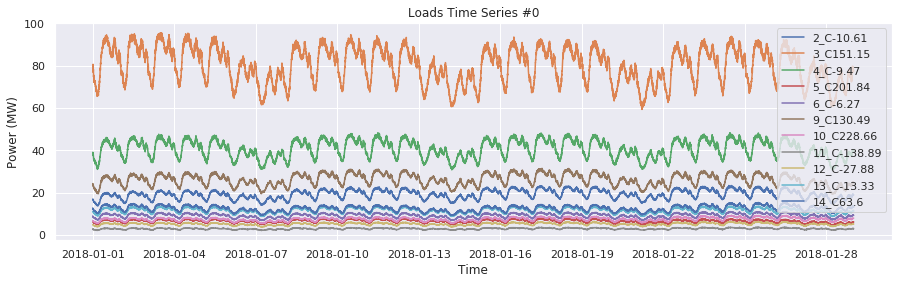

In [4]:
plt.figure(figsize=[15,4])
plt.title('Loads Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_loads_p[str(0)])
plt.legend(list(df_loads_p[str(0)]))
plt.show()

## Production

The active power of the productions is shown below. In the easy mode, each one of them is stable contrary to the medium and hard modes where the productions are much more heterogeneous.

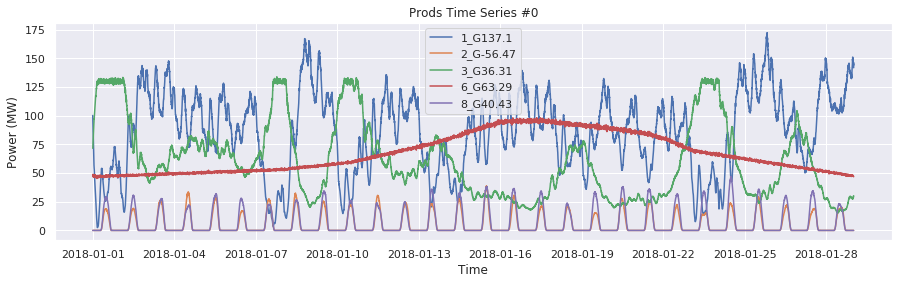

In [5]:
plt.figure(figsize=[15,4])
plt.title('Prods Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Power (MW)')
plt.plot(df_prods_p[str(0)])
plt.legend(list(df_prods_p[str(0)]))
plt.show()

## Maintenance

Maintenance exist only for the hard mode. When a maintenance happens for a production, the voltage magnitudes of the associated production is set to 0 in \_N\_prods\_v.csv for a number of timesteps. Here, two maintenances happen in January.

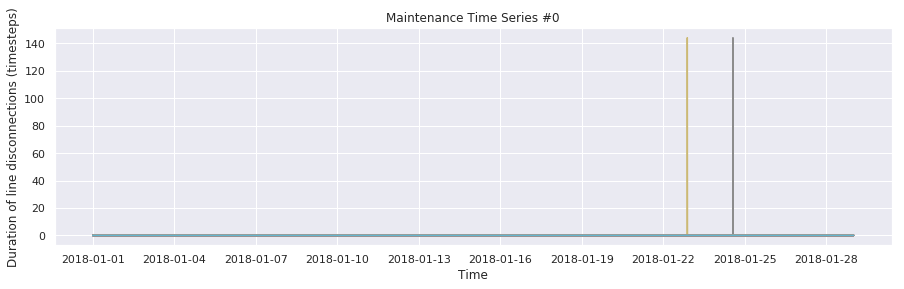

In [6]:
plt.figure(figsize=[15,4])
plt.title('Maintenance Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_maintenance[str(0)])
plt.show()

## Hazard

Again, hazards only happen with the hard mode. They represent external events that break lines from time to time, be it natural hazards or ones related to the network itself.

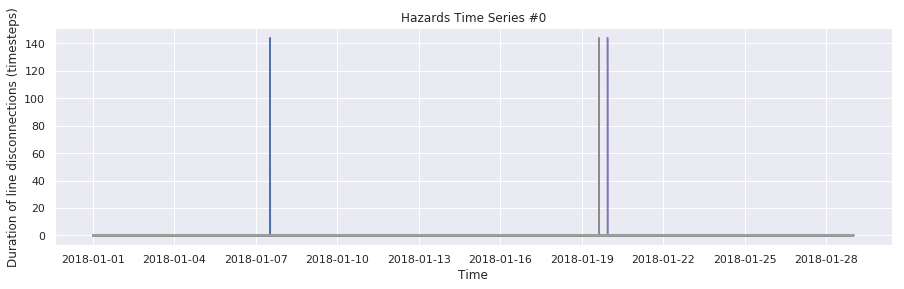

In [7]:
plt.figure(figsize=[15,4])
plt.title('Hazards Time Series #'+str(0))
plt.xlabel('Time')
plt.ylabel('Duration of line disconnections (timesteps)')
plt.plot(df_hazards[str(0)])
plt.show()

<div style="background:#FFFFAA">
<h1>Step 2: Building an Agent</h1>
</div>

<div style="background:#FFFFAA">
    <h2>Loading data with pypownet</h2>
    <p>
We reload the data with the environment class of pypownet
   <br>
    
To win, flows in a line have to stay under a threshold. Above this threshold, the line will overheat and after a certain amount of overheating, the line will break. Thermal limits are already defined in pypownet.
</div>

In [4]:
import os
import pypownet.environment
import pypownet.runner
data_dir = 'public_data'  
environment = pypownet.environment.RunEnv(parameters_folder=os.path.abspath(data_dir),
                                              game_level="hard",
                                              chronic_looping_mode='natural', start_id=0,
                                              game_over_mode="soft")

Using custom reward signal CustomRewardSignal of file /home/slaerd/Grid/starting_kit/public_data/reward_signal.py


<div style="background:#FFFFAA">
    <h2>Building an agent</h2>
    <p>
We provide examples of agent (for reinforcement learning) in the `starting-kit/example_submission` directory. It is a quite stupid agent: it does nothing. Replace it with your own agent.
    </div>

## Do nothing agent

The agent does not take any actions.

In [5]:
import pypownet.agent
import pypownet.environment


class DoNothingAgent(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)

    def act(self, observation):
        """ Produces an action given an observation of the environment. Takes as argument an observation of the current
        power grid, and returns the chosen action."""
        # Sanity check: an observation is a structured object defined in the environment file.
        assert isinstance(observation, pypownet.environment.Observation)

        action_space = self.environment.action_space

        # Implement your policy here
        # Example of the do-nothing policy that produces no action (i.e. an action that does nothing) each time
        do_nothing_action = action_space.get_do_nothing_action()

        # Sanity check: verify the good overall structure of the returned action; raises exceptions if not valid
        assert action_space.verify_action_shape(do_nothing_action)
        return do_nothing_action


In [6]:
from importlib import reload
from example_submission import baseline_agents
reload(baseline_agents)

<module 'example_submission.baseline_agents' from '/home/slaerd/Grid/starting_kit/example_submission/baseline_agents.py'>

In [7]:
from example_submission import baseline_agents
# Uncomment the next line to display the code of the DoNothing Agent
#??baseline_agents.DoNothingAgent

## RandomLineSwitch agent
The agent randomly switches the status of one random power line per timestep (if the random line is previously online, switch it off, otherwise switch it on

In [8]:
from example_submission import baseline_agents
# Uncomment the next line to display the code of the RandomLineSwitch Agent
#??baseline_agents.RandomLineSwitch

## RandomNodeSplitting agent
The agent selects a random switch configuration such that switched elements of the selected substations change the node within the substation on which they are directly wired.

In [9]:


from example_submission import baseline_agents
# Uncomment the next line to display the code of the RandomNodeSplitting Agent
#??baseline_agents.RandomNodeSplitting

<div style="background:#FFFFAA">
an instance of the agent (run the constructor) and attempt to reload a previously saved version from `starting_kit/example_submission/`:
    
</div>

## Scoring the results of an agent

<div style="background:#FFFFAA">
    <br>
    <p>
<b>The metric chosen for your challenge</b> is identified in the "metric.txt" file found in the `scoring_function/` directory. The function "get_metric" searches first for a metric having that name in my_metric.py, then in libscores.py, then in sklearn.metric.
    <br>
The aim of a reinforcement learning problem is to maximize the reward function.

When running the agent, two values are given back : the first one is the reward of the last timestep and the second one is the cumulative reward for all the iterations of the run of the agent. The reward indicates if the game is going towards a game over or not.

Specifically, our reward function is composed of 5 subrewards. They describe the proportion of isolated productions, loads, the cost of an action, an indication of the amount of changes between the current grid and the initial grid and lastly information on the lines capacity usage. 
    </div>

In [10]:
from scoring_program import libscores
from libscores import get_metric
metric_name, scoring_function = get_metric()
print('Using scoring metric:', metric_name)
# Uncomment the next line to display the code of the scoring metric
#??scoring_function

Using scoring metric: reward


### Run the Do nothing agent

In [11]:
import time
start = time.time()
end = time.time()
print(end-start)

5.53131103515625e-05


In [12]:
import logging
import sys
import os
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.DoNothingAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING AGENT !!! 
 DO NOTHING

In [17]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -11.27


### Run the RandomLineSwitch agent

In [18]:
import logging
import sys
start = time.time()
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomLineSwitch(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09194038054101689
Action chosen:  switching status of line 7 ; expected reward 0.0919
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09131097289601796
Action chosen:  switching status of line 16 ; expected reward 0.0913
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.0912251534817682
Action chosen:  switching status of line 14 ; expected reward 0.0912
reward: [ -0.00, -0.00, 0.20, -0.00, -0.11 ] = 0.09190574998027234
Action chosen:  switching status of line 16 ; expected reward 0.0919
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.07529781702936766
Action chosen:  switching status of line 10 ; expected reward 0.0753
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.07528964009311338
Action chosen:  switching status of line 7 ; expected reward 0.0753
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07255639128496405
Action chosen:  switching status of line 9 ; expected reward 0.0726
reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.072

/home/slaerd/ENV/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/sparse/linalg/dsolve/linsolve.py:192: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


reward: [ -0.00, -0.00, 0.20, -0.00, -0.13 ] = 0.07380906433110423
Action chosen:  switching status of line 16 ; expected reward 0.0738
reward: [ -0.00, -1.40, 0.20, -0.00, -0.11 ] = -1.3146273965793813
Action chosen:  switching status of line 0 ; expected reward -1.3146
reward: [ -0.00, -1.40, 0.20, -0.00, -0.11 ] = -1.3125492062177164
Action chosen:  switching status of line 15 ; expected reward -1.3125
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.12 ] = 0.07777923619471583
Action chosen:  switching status of line 16 ; expected reward 0.0778
reward: [ -0.00, -0.00, 0.20, -0.00, -0.14 ] = 0.06360353083433978
Action chosen:  switching status of line 6 ; expected reward 0.0636
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  switching status of line 12 ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.20, -0.00, -0.16 ] = 0.04344587328930416
Action ch

In [19]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -122.87


### Run the RandomNodeSplitting agent

In [20]:
import logging
import sys
start = time.time()
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.RandomNodeSplitting(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

reward: [ -2.80, -0.00, 0.30, -0.06, -0.16 ] = -2.7209598796612413
Action chosen:  change in topo of sub. 5 with switches array([0, 1, 0, 1, 1]) ; expected reward -2.7210
reward: [ 0.00, 0.00, 0.10, -14.00, 0.00 ] = -13.9
Action chosen:  change in topo of sub. 9 with switches array([0, 1, 0, 0, 0]) ; expected reward -13.9000
reward: [ -0.00, -0.00, 0.20, -0.04, -0.15 ] = 0.006706164298416056
Action chosen:  change in topo of sub. 10 with switches array([1, 0, 1]) ; expected reward 0.0067
reward: [ -0.00, -0.00, 0.30, -0.10, -0.20 ] = 0.0019832337855925364
Action chosen:  change in topo of sub. 13 with switches array([1, 1, 0, 1]) ; expected reward 0.0020
reward: [ -0.00, -0.00, 0.30, -0.16, -0.19 ] = -0.04708790910273267
Action chosen:  change in topo of sub. 9 with switches array([0, 1, 1, 0, 1]) ; expected reward -0.0471
reward: [ -0.00, -0.00, 0.00, -0.16, -0.19 ] = -0.3454752343655895
Action chosen:  change in topo of sub. 14 with switches array([0, 0, 0]) ; expected reward -0.3455

/home/slaerd/ENV/lib/python3.6/site-packages/PYPOWER-5.1.4-py3.6.egg/pypower/fdpf.py:121: RuntimeWarning: overflow encountered in multiply
  mis = (V * conj(Ybus * V) - Sbus) / Vm
/home/slaerd/ENV/lib/python3.6/site-packages/PYPOWER-5.1.4-py3.6.egg/pypower/fdpf.py:121: RuntimeWarning: invalid value encountered in multiply
  mis = (V * conj(Ybus * V) - Sbus) / Vm
/home/slaerd/ENV/lib/python3.6/site-packages/PYPOWER-5.1.4-py3.6.egg/pypower/fdpf.py:121: RuntimeWarning: invalid value encountered in true_divide
  mis = (V * conj(Ybus * V) - Sbus) / Vm
/home/slaerd/ENV/lib/python3.6/site-packages/numpy-1.15.4-py3.6-linux-x86_64.egg/numpy/core/_methods.py:28: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial)


reward: [ -0.00, -1.40, 0.10, -0.24, -0.25 ] = -1.786295407445957
Action chosen:  change in topo of sub. 12 with switches array([0, 0, 1]) ; expected reward -1.7863
reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
Action chosen:  change in topo of sub. 11 with switches array([1, 1, 0]) ; expected reward -13.8000
reward: [ -0.00, -0.00, 0.30, -0.06, -0.13 ] = 0.10694100310874513
Action chosen:  change in topo of sub. 10 with switches array([1, 1, 1]) ; expected reward 0.1069
reward: [ -0.00, -0.00, 0.30, -0.12, -0.15 ] = 0.03490773714026468
Action chosen:  change in topo of sub. 4 with switches array([1, 0, 0, 0, 1, 1]) ; expected reward 0.0349
reward: [ 0.00, 0.00, 0.30, -14.00, 0.00 ] = -13.7
Action chosen:  change in topo of sub. 5 with switches array([1, 0, 1, 1, 0]) ; expected reward -13.7000
reward: [ -2.80, -0.00, 0.50, -0.10, -0.11 ] = -2.505046699268568
Action chosen:  change in topo of sub. 4 with switches array([0, 1, 1, 1, 1, 1]) ; expected reward -2.5050
reward: [ -2.80, 

In [21]:
#get the score with the scoring_function
scoring_function(output_dir)

step : 50, cumulative rewards : -216.47


In [22]:
np.random.randint(19)

11

In [15]:
class CustomAgent(pypownet.agent.Agent):
    
    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = True
        
    def act(self, observation):
        print("\n///////// Iteration /////////")
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space
        expected_size = action_space.action_length
        
        action = action_space.get_do_nothing_action()
            
        lines_list = observation.get_lines_capacity_usage()
        #action_space.set_lines_status_switch_from_id(action=action,line_id=10,new_switch_value=1)
        
        
        
        """if not np.all(line_status):
            action_space.set_lines_status_switch_from_id(action=action,line_id=np.random.randint(action_space.lines_status_subaction_length),new_switch_value=1)"""
        action_space.set_lines_status_switch_from_id(action=action,line_id=np.random.randint(action_space.lines_status_subaction_length),new_switch_value=1)
        for i in range(action_space.lines_status_subaction_length - 1):
            if lines_list[i] > 0.5:
                action_space.set_lines_status_switch_from_id(action=action,line_id=i,new_switch_value=1)
        
        idList = np.arange(action_space.lines_status_subaction_length)
        line_status = action_space.get_lines_status_switch_from_id(action=action,line_id=idList)
        print(line_status)
        
        assert self.environment.action_space.verify_action_shape(action)
        
        return action

In [16]:
import logging
import sys
import time
start = time.time()
NUMBER_ITERATIONS = 50

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = CustomAgent(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)


///////// Iteration /////////
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]

///////// Iteration /////////
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]

///////// Iteration /////////
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]

///////// Iteration /////////
[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]

///////// Iteration /////////
[0 0 0 0 0 0 0 0 0 0

In [25]:
%debug

ERROR:root:No traceback has been produced, nothing to debug.


<div style="background:#FFFFAA">
    <b> Save the best agent </b> it should be a class Submission and save in "example_submission/submission.py".  Uncomment the line <i>%%writefile example_submission/submission.py to save the agent. </i>
</div>

In [18]:
%%writefile example_submission/submission.py
import pypownet.agent
import pypownet.environment
import numpy as np

class Submission(pypownet.agent.Agent):
    def __init__(self, environment):
        super().__init__(environment)
        self.verbose = True
        
    def act(self, observation):
        assert isinstance(observation, pypownet.environment.Observation)
        action_space = self.environment.action_space
        
        action = action_space.get_do_nothing_action() #We initialise an empty action
            
        lines_list = observation.get_lines_capacity_usage() #We monitor how charged the lines of our power network are
        
        #Without the following line, our grid would never be turned on resulting in our agent being a do_nothing agent
        action_space.set_lines_status_switch_from_id(action=action,line_id=np.random.randint(action_space.lines_status_subaction_length),new_switch_value=1)
        
        #Here, if a line's charge exceeds 80% of it's capacity, we turn it off
        for i in range(action_space.lines_status_subaction_length - 1):
            if lines_list[i] > 0.8:
                action_space.set_lines_status_switch_from_id(action=action,line_id=i,new_switch_value=1)
        
        #These are testing variables, allowing us to monitor the actions we take during the steps
        """idList = np.arange(action_space.lines_status_subaction_length)
        line_status = action_space.get_lines_status_switch_from_id(action=action,line_id=idList)
        print(line_status)"""
        
        assert self.environment.action_space.verify_action_shape(action)
        
        return action

Overwriting example_submission/submission.py


<div style="background:#FFFFAA">
<h1> Step 3: Making a submission </h1> 

<h2> Unit testing </h2> 

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>submission.py</code> in the <code>starting_kit/example_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission. 
<br>
Keep the sample code simple.
</div>

In [19]:
!python $problem_dir/ingestion.py $input_dir $input_dir/res $problem_dir $model_dir

input dir: /home/slaerd/Grid/starting_kit/public_data
output dir: /home/slaerd/Grid/starting_kit/public_data/res
program dir: /home/slaerd/Grid/starting_kit/ingestion_program
submission dir: /home/slaerd/Grid/starting_kit/example_submission
input content ['__pycache__', 'easy', 'hard', 'level0', 'medium', 'res', 'reward_signal.py']
output content ['runner.log']
program content ['__pycache__', 'data_converter.py', 'data_io.py', 'data_manager.py', 'ingestion.py', 'metadata']
submission content ['__pycache__', 'baseline_agents.py', 'metadata', 'my_agents.py', 'submission.py']
Using custom reward signal CustomRewardSignal of file /home/slaerd/Grid/starting_kit/public_data/reward_signal.py
log file path /home/slaerd/Grid/starting_kit/public_data/res/runner.log
Overall time spent 20.69 sec 


<div style="background:#FFFFAA">
Also test the scoring program:
    </div>

In [20]:
scoring_output_dir = 'output'
!python $score_dir/evaluate.py $input_dir $scoring_output_dir

public_data/
output
step : 1000, cumulative rewards : -2870.35


<div style="background:#FFFFAA">
    <h1> Preparing the submission </h1>

Zip the contents of `sample_code_submission/` (without the directory), or download the challenge public_data and run the command in the previous cell, after replacing sample_data by public_data.
Then zip the contents of `sample_result_submission/` (without the directory).
<b><span style="color:red">Do NOT zip the data with your submissions</span></b>.

In [21]:
import datetime 
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
sample_code_submission = 'sample_code_submission_' + the_date + '.zip' 
zipdir(sample_code_submission, model_dir) 
print("Submit one of these files:\n" + sample_code_submission + "\n")

Submit one of these files:
sample_code_submission_19-03-08-23-47.zip



In [22]:
import logging
import sys
import time
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.GreedySearch(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

Storing actions at saved_actions.csv
 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.00, -0.15 ] = -0.14720414441205126
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.00, -0.19 ] = 0.01137015966182367
 Simulation with switching status of line 1; reward: [ -0.00, -0.00, 0.20, -0.00, -0.20 ] = 0.00012727072052506894
 Simulation with switching status of line 2; reward: [ -0.00, -0.00, 0.20, -0.00, -0.16 ] = 0.04200554598939907
 Simulation with switching status of line 3; reward: [ -0.00, -0.00, 0.20, -0.00, -0.17 ] = 0.026353128860727604
 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.00, -0.15 ] = 0.04782145930004403
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.00, -0.23 ] = -0.0286720162467137
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.00, -0.17 ] = 0.029393371451775563
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.

/home/slaerd/ENV/lib/python3.6/site-packages/scipy-1.1.0-py3.6-linux-x86_64.egg/scipy/sparse/linalg/dsolve/linsolve.py:192: MatrixRankWarning: Matrix is exactly singular
  warn("Matrix is exactly singular", MatrixRankWarning)


; reward: [ -0.00, -0.00, 0.20, -0.04, -0.17 ] = -0.012135313343629966
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 1]; reward: [ 0.00, 0.00, 0.30, -14.00, 0.00 ] = -13.7
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 0]; reward: [ -0.00, -0.00, 0.20, -0.04, -0.15 ] = 0.008016881896957706
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 1]; reward: [ -0.00, -0.00, 0.30, -0.06, -0.15 ] = 0.09490419599753258
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.06, -0.15 ] = 0.09017347314042345
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 1]; reward: [ -2.80, -0.00, 0.40, -0.08, -0.07 ] = -2.549340305034219
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.00, -0.15 ] = -0.14720414441205126
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.02

 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.34 ] = -0.08468604235312915
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 1]; reward: [ -0.00, -0.00, 0.40, -0.02, -0.17 ] = 0.21142171293953466
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.06, -0.14 ] = -0.20369870161809608
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.15 ] = -0.12583434309944463
 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.17 ] = -0.15108417027668042
 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.27 ] = -0.16820559465234694
 Simulation with change in topo of sub. 13 with switches [0, 1, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.17 ] = -0.15096919007295695
 Simulation with change 

 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.39 ] = -0.24680763371145908
 Simulation with change in topo of sub. 13 with switches [0, 1, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.25 ] = -0.18560860631952375
 Simulation with change in topo of sub. 13 with switches [0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.18 ] = -0.03676631425079166
 Simulation with change in topo of sub. 13 with switches [0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.0257751148284579
 Simulation with change in topo of sub. 13 with switches [0, 1, 1, 1]; reward: [ -2.80, -0.00, 0.30, -0.08, -0.13 ] = -2.7137092316597897
Action chosen:  change in topo of sub. 9 with switches [0, 1, 1, 1, 1] ; expected reward 0.1977
 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.06, -0.14 ] = -0.2016454987414264
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.06, -0.18 ] = -0.04005223124630011
 Si

 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.02, -0.16 ] = -0.18320056073982555
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.02, -0.19 ] = -0.010845933506184596
 Simulation with switching status of line 1; reward: [ -0.00, -0.00, 0.20, -0.02, -0.21 ] = -0.031742738944867344
 Simulation with switching status of line 2; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.00588076215299746
 Simulation with switching status of line 3; reward: [ -0.00, -0.00, 0.20, -0.02, -0.19 ] = -0.00707316251596285
 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.013679030785229501
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.02, -0.24 ] = -0.05996206987310196
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.02, -0.18 ] = 0.0036656629969057386
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.02, -0.20 ] = -0.0188032755911602

 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.06, -0.14 ] = -0.2000286346156402
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.03352617012856193
 Simulation with switching status of line 1; reward: [ -0.00, -0.00, 0.20, -0.06, -0.18 ] = -0.0387700907017009
 Simulation with switching status of line 2; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.009438619151683592
 Simulation with switching status of line 3; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.02806802667776076
 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.005138981241649243
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.06, -0.22 ] = -0.08052701661042755
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.02824118865651068
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.006111376253273071

 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.02, -0.16 ] = -0.18064611592746735
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.02, -0.18 ] = -0.004557904547932423
 Simulation with switching status of line 1; reward: [ -0.00, -0.00, 0.20, -0.02, -0.21 ] = -0.025855676247818676
 Simulation with switching status of line 2; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.008671054421467317
 Simulation with switching status of line 3; reward: [ -0.00, -0.00, 0.20, -0.02, -0.18 ] = -0.004154375551854911
 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.01657886578419865
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.02, -0.24 ] = -0.05601024057830972
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.007391651058602844
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.02, -0.19 ] = -0.0096312084793256

 Simulation with switching status of line 3; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.027161150743517354
 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14 ] = -0.004183984506755667
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.06, -0.22 ] = -0.0785875796330513
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.025966520140302624
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.00895669474961655
 Simulation with switching status of line 8; reward: [ -2.80, -0.00, 0.20, -0.06, -0.07 ] = -2.7326277116539317
 Simulation with switching status of line 9; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14 ] = -0.003941742933727427
 Simulation with switching status of line 10; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.025042737150366146
 Simulation with switching status of line 11; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] =

 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.02, -0.23 ] = -0.0526499004399234
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.010868818686683046
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.02, -0.18 ] = -0.0015300706690250243
 Simulation with switching status of line 8; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.02160550142832679
 Simulation with switching status of line 9; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.02423486629647803
 Simulation with switching status of line 10; reward: [ -0.00, -0.00, 0.20, -0.02, -0.20 ] = -0.023012294353815382
 Simulation with switching status of line 11; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.005695449403030933
 Simulation with switching status of line 12; reward: [ -2.80, -0.00, 0.20, -0.02, -0.15 ] = -2.773587661164966
 Simulation with switching status of line 13; reward: [ -0.00, -1.40, 0.20, -0.02, -0.22 ] = -1

 Simulation with switching status of line 10; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.02325724147255878
 Simulation with switching status of line 11; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.008832778124169216
 Simulation with switching status of line 12; reward: [ -2.80, -0.00, 0.20, -0.06, -0.14 ] = -2.796080409220184
 Simulation with switching status of line 13; reward: [ -0.00, -1.40, 0.20, -0.06, -0.18 ] = -1.441085121486385
 Simulation with switching status of line 14; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.027572544967733148
 Simulation with switching status of line 15; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14 ] = -0.00039392968518370264
 Simulation with switching status of line 16; reward: [ -2.80, -0.00, 0.20, -0.06, -0.12 ] = -2.7806469315550286
 Simulation with switching status of line 17; reward: [ -0.00, -0.00, 0.20, -0.06, -0.13 ] = 0.007446872863923759
 Simulation with switching status of line 18; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14

 Simulation with switching status of line 13; reward: [ -0.00, -1.40, 0.20, -0.02, -0.22 ] = -1.4413084291867475
 Simulation with switching status of line 14; reward: [ -0.00, -0.00, 0.20, -0.02, -0.36 ] = -0.18352228101198484
 Simulation with switching status of line 15; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.02466289745867234
 Simulation with switching status of line 16; reward: [ -2.80, -0.00, 0.20, -0.02, -0.12 ] = -2.7401290846676316
 Simulation with switching status of line 17; reward: [ -0.00, -0.00, 0.20, -0.02, -0.14 ] = 0.04498794684313717
 Simulation with switching status of line 18; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.019864417311650007
 Simulation with switching status of line 19; reward: [ -0.00, -0.00, 0.20, -0.02, -0.22 ] = -0.044983590677458996
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.02, -0.16 ] = -0.1758678783975053
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 1]

 Simulation with switching status of line 16; reward: [ -2.80, -0.00, 0.20, -0.06, -0.12 ] = -2.781112713506391
 Simulation with switching status of line 17; reward: [ -0.00, -0.00, 0.20, -0.06, -0.13 ] = 0.0077924377668252
 Simulation with switching status of line 18; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14 ] = 0.000758483732094084
 Simulation with switching status of line 19; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.01693033341961292
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.06, -0.14 ] = -0.19753241595360985
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.75 ] = -0.7343021680186279
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -1.05 ] = -1.0304573236381198
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 1]; reward: [ -2.80, -1.40, 0.20, -0.10, -0.85 ] = -4.949901897546005


 Simulation with switching status of line 18; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.02188891672682272
 Simulation with switching status of line 19; reward: [ -0.00, -0.00, 0.20, -0.02, -0.22 ] = -0.04087202417373556
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.17394673006501427
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.74 ] = -0.682694388562971
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -1.01 ] = -0.9535598534403273
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 1]; reward: [ -2.80, -1.40, 0.20, -0.06, -0.83 ] = -4.885031250685611
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 0]; reward: [ -2.80, -0.00, 0.10, -0.04, -0.48 ] = -3.2193538701190336
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 1]; reward: [ -0.00, -0

 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 0]; reward: [ -2.80, -0.00, 0.10, -0.08, -0.46 ] = -3.2383776231394044
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.70 ] = -0.5959490123578187
 Simulation with change in topo of sub. 3 with switches [0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -1.13 ] = -1.031862044894635
 Simulation with change in topo of sub. 3 with switches [0, 1, 1, 1]; reward: [ -0.00, -1.40, 0.30, -0.12, -0.70 ] = -1.921634085960834
 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.06, -0.14 ] = -0.19733570690585883
 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.16 ] = -0.13870478117748353
 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.14 ] = -0.11733570690585883
 Simulation with change in topo

 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.16 ] = -0.10060372396975084
 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.15 ] = -0.09305286916981506
 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.020603723969750826
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.19 ] = -0.12541105981125386
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.027425417060831903
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.19 ] = -0.045411059811253845
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.08, -0.17 ] = 0.05257458293916811
 Simulation

 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.16 ] = -0.06163495848162326
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.12, -0.14 ] = 0.04376204564834654
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.15 ] = -0.1253410009863234
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.14 ] = -0.04349271620944287
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.15 ] = -0.045341000986323376
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.12, -0.14 ] = 0.03650728379055718
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 0, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.18 ] = -0.08200962237712725
 Simulation wit

 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.021488553703336855
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.009350094693640565
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.08, -0.16 ] = 0.05851144629666316
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 0, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.18 ] = -0.03566215507323528
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 0, 1]; reward: [ -2.80, -0.00, 0.30, -0.08, -0.15 ] = -2.726000100514718
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.08, -0.18 ] = 0.044337844926764736
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 1, 1]; reward: [ -2.80, -0.00, 0.40, -0.10, -0.15 ] = -2.646000100514718
 Simulation with

 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 0, 1]; reward: [ -2.80, -0.00, 0.30, -0.12, -0.13 ] = -2.75299362592431
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.12, -0.18 ] = -0.000964631163535068
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 1, 1]; reward: [ -2.80, -0.00, 0.40, -0.14, -0.13 ] = -2.67299362592431
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.06, -0.14 ] = -0.19795702311152855
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.15 ] = -0.08657051644038005
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 1, 0]; reward: [ -2.80, -0.00, 0.10, -0.08, -0.08 ] = -2.8626460853561304
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.13 ] = 0.008600299533144784
 Simulation with ch

 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.15 ] = -0.08637844390407151
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 0, 1]; reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.02, -0.13 ] = 0.04584849698788401
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.16 ] = 0.10355524761593393
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.13 ] = 0.008837793882645384
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 1]; reward: [ -2.80, -0.00, 0.30, -0.08, -0.08 ] = -2.663826178450128
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.15 ] = 0.11322542892227161
 Simulation with change in topo of 

 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.15 ] = -0.08732018172627529
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 0, 1]; reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.28 ] = -0.13931757879796675
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.14 ] = 0.12452730088778782
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 0]; reward: [ -0.00, -0.00, 0.20, -0.02, -0.18 ] = 0.0048407733358839244
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 1]; reward: [ -0.00, -0.00, 0.30, -0.00, -0.14 ] = 0.16476402487094371
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.37 ] = -0.11078501296084331
 Simulation with change in topo

 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 1]; reward: [ -2.80, -0.00, 0.30, -0.08, -0.09 ] = -2.66557211829213
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.15 ] = 0.11285918440582118
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 1]; reward: [ -0.00, -0.00, 0.40, -0.06, -0.14 ] = 0.20157317597142724
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.17156181093834763
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.16 ] = -0.09541318396376544
 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.19 ] = -0.13273694004741754
 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.34 ] = -0.2040355517387888
 Simulation with change in 

 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.17175544934063966
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.022120195424758377
 Simulation with switching status of line 1; reward: [ -0.00, -0.00, 0.20, -0.02, -0.18 ] = 0.0027360079054645214
 Simulation with switching status of line 2; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.01707549899195923
 Simulation with switching status of line 3; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.008007307653542295
 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.02, -0.15 ] = 0.027540981139007437
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.02, -0.22 ] = -0.04172703882193157
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.022888026265473094
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.024775178375145285


 Simulation with switching status of line 4; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14 ] = -0.002467926434845058
 Simulation with switching status of line 5; reward: [ -0.00, -0.00, 0.20, -0.06, -0.21 ] = -0.07364930891498059
 Simulation with switching status of line 6; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.016654938934897945
 Simulation with switching status of line 7; reward: [ -0.00, -0.00, 0.20, -0.06, -0.18 ] = -0.039439131330256644
 Simulation with switching status of line 8; reward: [ -2.80, -0.00, 0.20, -0.06, -0.09 ] = -2.747894133407489
 Simulation with switching status of line 9; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.009337392536755168
 Simulation with switching status of line 10; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.02201404955805722
 Simulation with switching status of line 11; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.009616903105204383
 Simulation with switching status of line 12; reward: [ -2.80, -0.00, 0.20, -0.06, -0.14 ] 

 Simulation with switching status of line 10; reward: [ -0.00, -0.00, 0.20, -0.02, -0.19 ] = -0.012744495633336628
 Simulation with switching status of line 11; reward: [ -0.00, -0.00, 0.20, -0.02, -0.17 ] = 0.012935419703090756
 Simulation with switching status of line 12; reward: [ -2.80, -0.00, 0.20, -0.02, -0.15 ] = -2.7686663589200906
 Simulation with switching status of line 13; reward: [ -0.00, -1.40, 0.20, -0.02, -0.22 ] = -1.4408967805091333
 Simulation with switching status of line 14; reward: [ -0.00, -0.00, 0.20, -0.02, -0.38 ] = -0.20461310854341794
 Simulation with switching status of line 15; reward: [ -0.00, -0.00, 0.20, -0.02, -0.15 ] = 0.030043063995765174
 Simulation with switching status of line 16; reward: [ -2.80, -0.00, 0.20, -0.02, -0.12 ] = -2.7408079476150813
 Simulation with switching status of line 17; reward: [ -0.00, -0.00, 0.20, -0.02, -0.13 ] = 0.04588588179372308
 Simulation with switching status of line 18; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] 

 Simulation with switching status of line 9; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.01006957395722985
 Simulation with switching status of line 10; reward: [ -0.00, -0.00, 0.20, -0.06, -0.16 ] = -0.022179513268951706
 Simulation with switching status of line 11; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.009927038718446413
 Simulation with switching status of line 12; reward: [ -2.80, -0.00, 0.20, -0.06, -0.14 ] = -2.799239289622799
 Simulation with switching status of line 13; reward: [ -0.00, -1.40, 0.20, -0.06, -0.18 ] = -1.4389379200006123
 Simulation with switching status of line 14; reward: [ -0.00, -0.00, 0.20, -0.06, -0.18 ] = -0.040107193783587985
 Simulation with switching status of line 15; reward: [ -0.00, -0.00, 0.20, -0.06, -0.15 ] = -0.006394272679678931
 Simulation with switching status of line 16; reward: [ -2.80, -0.00, 0.20, -0.06, -0.13 ] = -2.788225210415387
 Simulation with switching status of line 17; reward: [ -0.00, -0.00, 0.20, -0.06, -0.14 ]

 Simulation with switching status of line 12; reward: [ -2.80, -0.00, 0.20, -0.02, -0.15 ] = -2.768750692856439
 Simulation with switching status of line 13; reward: [ -0.00, -1.40, 0.20, -0.02, -0.22 ] = -1.4410142570064457
 Simulation with switching status of line 14; reward: [ -0.00, -0.00, 0.20, -0.02, -0.39 ] = -0.2061346402270666
 Simulation with switching status of line 15; reward: [ -0.00, -0.00, 0.20, -0.02, -0.15 ] = 0.030120718504548755
 Simulation with switching status of line 16; reward: [ -2.80, -0.00, 0.20, -0.02, -0.12 ] = -2.741168924412752
 Simulation with switching status of line 17; reward: [ -0.00, -0.00, 0.20, -0.02, -0.13 ] = 0.045657970420206084
 Simulation with switching status of line 18; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.024203161686615432
 Simulation with switching status of line 19; reward: [ -0.00, -0.00, 0.20, -0.02, -0.21 ] = -0.03069982030602475
 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 

 Simulation with change in topo of sub. 3 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.73 ] = -0.7090993698586829
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -1.01 ] = -0.9933714008612238
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 1]; reward: [ -2.80, -1.40, 0.20, -0.10, -0.80 ] = -4.902459343499801
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 0]; reward: [ -2.80, -0.00, 0.10, -0.08, -0.47 ] = -3.245880709174704
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.70 ] = -0.603093870284942
 Simulation with change in topo of sub. 3 with switches [0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -1.13 ] = -1.0302784391884796
 Simulation with change in topo of sub. 3 with switches [0, 1, 1, 1]; reward: [ -0.00, -1.40, 0.30, -0.12, -0.67 ] = -1.8866825273210988
 Simulation with change in topo of sub. 5 wi

 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -1.00 ] = -0.9374111684574047
 Simulation with change in topo of sub. 3 with switches [0, 0, 1, 1]; reward: [ -2.80, -1.40, 0.20, -0.06, -0.79 ] = -4.853596527993333
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 0]; reward: [ -2.80, -0.00, 0.10, -0.04, -0.49 ] = -3.2266775440678344
 Simulation with change in topo of sub. 3 with switches [0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.73 ] = -0.586075672642914
 Simulation with change in topo of sub. 3 with switches [0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -1.15 ] = -1.005338347423864
 Simulation with change in topo of sub. 3 with switches [0, 1, 1, 1]; reward: [ -0.00, -1.40, 0.30, -0.08, -0.68 ] = -1.8598889229137334
 Simulation with change in topo of sub. 5 with switches [0, 0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.17252817494001083
 Simulation with change in topo of sub. 

 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.16 ] = -0.1393172418280305
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.14 ] = -0.040391463171192826
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.16 ] = -0.059317241828030526
 Simulation with change in topo of sub. 5 with switches [0, 0, 1, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.12, -0.14 ] = 0.03960853682880722
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.15 ] = -0.13163413495503024
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.14 ] = -0.04459056657904942
 Simulation with change in topo of sub. 5 with switches [0, 1, 0, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.15 ] = -0.05163413495503022
 Simulation w

 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 0, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.17 ] = -0.03254037210891603
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 0, 1]; reward: [ -2.80, -0.00, 0.30, -0.08, -0.15 ] = -2.727148762252145
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.08, -0.17 ] = 0.04745962789108399
 Simulation with change in topo of sub. 5 with switches [0, 1, 1, 1, 1]; reward: [ -2.80, -0.00, 0.40, -0.10, -0.15 ] = -2.647148762252145
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.1727411812337507
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.38 ] = -0.3214186010004762
 Simulation with change in topo of sub. 9 with switches [0, 0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.00, -0.14 ] = -0.037418847075753825
 Simulation with ch

 Simulation with change in topo of sub. 9 with switches [0, 0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.02, -0.14 ] = 0.04292536886041334
 Simulation with change in topo of sub. 9 with switches [0, 0, 1, 1, 0]; reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
 Simulation with change in topo of sub. 9 with switches [0, 0, 1, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.15 ] = 0.11338269476569063
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.15 ] = -0.0932527467934619
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 0, 1]; reward: [ 0.00, 0.00, 0.20, -14.00, 0.00 ] = -13.8
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.29 ] = -0.1487770057373085
 Simulation with change in topo of sub. 9 with switches [0, 1, 0, 1, 1]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.14 ] = 0.12247521938411005
 Simulation with change in topo of sub. 9 with switc

 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 0, 1]; reward: [ -2.80, -0.00, 0.30, -0.08, -0.09 ] = -2.671363823157629
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 0]; reward: [ -0.00, -0.00, 0.30, -0.04, -0.15 ] = 0.10793224167642318
 Simulation with change in topo of sub. 9 with switches [0, 1, 1, 1, 1]; reward: [ -0.00, -0.00, 0.40, -0.06, -0.14 ] = 0.1971614539572394
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 0]; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.17404949594310598
 Simulation with change in topo of sub. 13 with switches [0, 0, 0, 1]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.16 ] = -0.09779980138931732
 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 0]; reward: [ -0.00, -0.00, 0.10, -0.04, -0.19 ] = -0.13450556397046115
 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.06, -0.34 ] = -0.20288371800433297
 Simulation with change in

 Simulation with change in topo of sub. 13 with switches [0, 0, 1, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.24 ] = -0.1399058652604706
 Simulation with change in topo of sub. 13 with switches [0, 1, 0, 0]; reward: [ -0.00, -0.00, 0.10, -0.08, -0.16 ] = -0.13691948333002096
 Simulation with change in topo of sub. 13 with switches [0, 1, 0, 1]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.14 ] = -0.04393805660893088
 Simulation with change in topo of sub. 13 with switches [0, 1, 1, 0]; reward: [ -0.00, -0.00, 0.20, -0.10, -0.15 ] = -0.048024416005463616
 Simulation with change in topo of sub. 13 with switches [0, 1, 1, 1]; reward: [ -2.80, -0.00, 0.30, -0.12, -0.13 ] = -2.7547464675010698
Action chosen:  change in topo of sub. 9 with switches [0, 1, 1, 1, 1] ; expected reward 0.2258
 Simulation with no action; reward: [ -0.00, -0.00, 0.00, -0.02, -0.15 ] = -0.17461765192435927
 Simulation with switching status of line 0; reward: [ -0.00, -0.00, 0.20, -0.02, -0.16 ] = 0.01923094768076511
 S

KeyboardInterrupt: 

In [31]:
import logging
import sys
import time
start = time.time()
NUMBER_ITERATIONS = 50 # The number of iterations can be changed

submission_dir = 'example_submission'
sys.path.append(submission_dir)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)
log_path = os.path.abspath(os.path.join(output_dir, 'runner.log'))


open(log_path, 'w').close()
submitted_controler = baseline_agents.TreeSearchLineServiceStatus(environment)
# Instanciate a runner, that will save the run statistics within the log_path file, to be parsed and processed
# by the scoring program
phase_runner = pypownet.runner.Runner(environment, submitted_controler, verbose=True, vverbose=False,
                                      log_filepath=log_path)
phase_runner.ch.setLevel(logging.ERROR)
# Run the planned experiment of this phase with the submitted model
score = phase_runner.loop(iterations=NUMBER_ITERATIONS)
print("cumulative rewards : {}".format(score))
end = time.time()
print(end-start)

Storing actions at saved_actions_TreeSearchLineServiceStatus.csv
    Simulating switch activation line 0; expected reward -0.07204
    Simulating switch activation line 1; expected reward -0.05533
    Simulating switch activation line 2; expected reward -0.00239
    Simulating switch activation line 3; expected reward -0.02662
    Simulating switch activation line 4; expected reward -0.01438
    Simulating switch activation line 5; expected reward -4.34852
    Simulating switch activation line 6; expected reward -0.03426
    Simulating switch activation line 7; expected reward -13.80000
    Simulating switch activation line 8; expected reward -0.01884
    Simulating switch activation line 9; expected reward -0.00779
    Simulating switch activation line 10; expected reward -0.03919
    Simulating switch activation line 11; expected reward -0.02850
    Simulating switch activation line 12; expected reward -0.04577
    Simulating switch activation line 13; expected reward -1.41884
    Si

INFO:pypownet:step 1/50 - reward: -0.09; cumulative reward: -0.09


; expected reward -0.02077
    Simulating switch activation line 19; expected reward -0.03592
    Simulating switch activation line 19  Best simulated action: disconnect line 2; expected reward: -0.00239
    Simulating switch activation line 0; expected reward -0.06475
    Simulating switch activation line 1; expected reward -0.05728
    Simulating switch activation line 2; expected reward -0.02494
    Simulating switch activation line 3; expected reward -0.03352
    Simulating switch activation line 4; expected reward -0.00371
    Simulating switch activation line 5; expected reward -0.10366
    Simulating switch activation line 6; expected reward -0.03845
    Simulating switch activation line 7; expected reward -13.80000
    Simulating switch activation line 8; expected reward -0.01024
    Simulating switch activation line 9; expected reward 0.00562
    Simulating switch activation line 10; expected reward -0.03053
    Simulating switch activation line 11; expected reward -0.02001
  

INFO:pypownet:step 2/50 - reward: -0.08; cumulative reward: -0.16


; expected reward -0.01309
    Simulating switch activation line 16; expected reward -0.01070
    Simulating switch activation line 17; expected reward -0.02524
    Simulating switch activation line 18; expected reward -0.01213
    Simulating switch activation line 19; expected reward -0.02671
    Simulating switch activation line 19  Best simulated action: disconnect line 9; expected reward: 0.00562
    Simulating switch activation line 0; expected reward -0.05251
    Simulating switch activation line 1; expected reward -0.05656
    Simulating switch activation line 2; expected reward -0.01709
    Simulating switch activation line 3; expected reward -0.01940
    Simulating switch activation line 4; expected reward 0.00359
    Simulating switch activation line 5; expected reward -0.08486
    Simulating switch activation line 6; expected reward -0.01313
    Simulating switch activation line 7; expected reward -0.05471
    Simulating switch activation line 8; expected reward -0.00082
   

INFO:pypownet:step 3/50 - reward: -0.12; cumulative reward: -0.28


    Simulating switch activation line 0; expected reward -0.06882
    Simulating switch activation line 1; expected reward -0.09625
    Simulating switch activation line 2; expected reward -0.01584
    Simulating switch activation line 3; expected reward -0.02217
    Simulating switch activation line 4; expected reward -0.00537
    Simulating switch activation line 5; expected reward -0.08533
    Simulating switch activation line 6; expected reward -0.01421
    Simulating switch activation line 7; expected reward -0.06506
    Simulating switch activation line 8; expected reward -0.00066
    Simulating switch activation line 9; expected reward -0.01682
    Simulating switch activation line 10; expected reward -0.03008
    Simulating switch activation line 11; expected reward -0.01301
    Simulating switch activation line 12; expected reward -0.04690
    Simulating switch activation line 13; expected reward -1.40066
    Simulating switch activation line 14; expected reward -0.06506
    S

INFO:pypownet:step 4/50 - reward: -0.09; cumulative reward: -0.37


    Simulating switch activation line 0; expected reward -0.07301
    Simulating switch activation line 1; expected reward -0.10279
    Simulating switch activation line 2; expected reward -0.01695
    Simulating switch activation line 3; expected reward -0.02385
    Simulating switch activation line 4; expected reward -0.00706
    Simulating switch activation line 5; expected reward -0.08591
    Simulating switch activation line 6; expected reward -0.01665
    Simulating switch activation line 7; expected reward -0.08932
    Simulating switch activation line 8; expected reward -0.00233
    Simulating switch activation line 9; expected reward -0.02472
    Simulating switch activation line 10; expected reward -0.03689
    Simulating switch activation line 11; expected reward -0.01581
    Simulating switch activation line 12; expected reward -0.06851
    Simulating switch activation line 13; expected reward -1.40233
    Simulating switch activation line 14; expected reward -0.08932
    S

INFO:pypownet:step 5/50 - reward: -0.21; cumulative reward: -0.59


; expected reward -2.75120
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: -0.00233
    Simulating switch activation line 0; expected reward -0.07551
    Simulating switch activation line 1; expected reward -0.10506
    Simulating switch activation line 2; expected reward -0.01792
    Simulating switch activation line 3; expected reward -0.02510
    Simulating switch activation line 4; expected reward -0.00830
    Simulating switch activation line 5; expected reward -0.08690
    Simulating switch activation line 6; expected reward -0.01807
    Simulating switch activation line 7; expected reward -0.09091
    Simulating switch activation line 8; expected reward -0.00347
    Simulating switch activation line 9; expected reward -0.02608
    Simulating switch activation line 10; expected reward -0.03804
    Simulating switch activation line 11; expected reward -0.01696
    Simulating switch activation line 12; expected reward -0.07003
  

INFO:pypownet:step 6/50 - reward: -0.11; cumulative reward: -0.70


; expected reward -0.09091
    Simulating switch activation line 15; expected reward -0.00479
    Simulating switch activation line 16; expected reward -0.01248
    Simulating switch activation line 17; expected reward -0.04845
    Simulating switch activation line 18; expected reward -0.00694
    Simulating switch activation line 19; expected reward -2.75212
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: -0.00347
    Simulating switch activation line 0; expected reward -0.07363
    Simulating switch activation line 1; expected reward -0.10341
    Simulating switch activation line 2; expected reward -0.01721
    Simulating switch activation line 3; expected reward -0.02424
    Simulating switch activation line 4; expected reward -0.00738
    Simulating switch activation line 5; expected reward -0.08631
    Simulating switch activation line 6; expected reward -0.01705
    Simulating switch activation line 7; expected reward -0.08956


INFO:pypownet:step 7/50 - reward: -0.07; cumulative reward: -0.77


; expected reward -0.01611
    Simulating switch activation line 12; expected reward -0.06886
    Simulating switch activation line 13; expected reward -1.40263
    Simulating switch activation line 14; expected reward -0.08956
    Simulating switch activation line 15; expected reward -0.00394
    Simulating switch activation line 16; expected reward -0.01152
    Simulating switch activation line 17; expected reward -0.04734
    Simulating switch activation line 18; expected reward -0.00609
    Simulating switch activation line 19; expected reward -2.75144
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: -0.00263
    Simulating switch activation line 0; expected reward -0.06839
    Simulating switch activation line 1; expected reward -0.09770
    Simulating switch activation line 2; expected reward -0.01511
    Simulating switch activation line 3; expected reward -0.02112
    Simulating switch activation line 4; expected reward -0.004

INFO:pypownet:step 8/50 - reward: -0.07; cumulative reward: -0.85


; expected reward -2.74955
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.00007
    Simulating switch activation line 0; expected reward -0.06299
    Simulating switch activation line 1; expected reward -0.09223
    Simulating switch activation line 2; expected reward -0.01337
    Simulating switch activation line 3; expected reward -0.01840
    Simulating switch activation line 4; expected reward -0.00191
    Simulating switch activation line 5; expected reward -0.08235
    Simulating switch activation line 6; expected reward -0.01106
    Simulating switch activation line 7; expected reward -0.08283
    Simulating switch activation line 8; expected reward 0.00249
    Simulating switch activation line 9; expected reward -0.01812
    Simulating switch activation line 10; expected reward -0.03159
    Simulating switch activation line 11; expected reward -0.01085
    Simulating switch activation line 12; expected reward -0.06295
    

INFO:pypownet:step 9/50 - reward: -0.12; cumulative reward: -0.97


; expected reward 0.00122
    Simulating switch activation line 16; expected reward -0.00644
    Simulating switch activation line 17; expected reward -0.04158
    Simulating switch activation line 18; expected reward -0.00090
    Simulating switch activation line 19; expected reward -2.74814
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.00249
    Simulating switch activation line 0; expected reward -0.05735
    Simulating switch activation line 1; expected reward -0.08621
    Simulating switch activation line 2; expected reward -0.01109
    Simulating switch activation line 3; expected reward -0.01520
    Simulating switch activation line 4; expected reward 0.00113
    Simulating switch activation line 5; expected reward -0.07995
    Simulating switch activation line 6; expected reward -0.00781
    Simulating switch activation line 7; expected reward -0.07913
    Simulating switch activation line 8; expected reward 0.00536
    S

INFO:pypownet:step 10/50 - reward: -0.09; cumulative reward: -1.06


    Simulating switch activation line 0; expected reward -0.05428
    Simulating switch activation line 1; expected reward -0.08307
    Simulating switch activation line 2; expected reward -0.01026
    Simulating switch activation line 3; expected reward -0.01362
    Simulating switch activation line 4; expected reward 0.00260
    Simulating switch activation line 5; expected reward -0.07919
    Simulating switch activation line 6; expected reward -0.00615
    Simulating switch activation line 7; expected reward -0.07722
    Simulating switch activation line 8; expected reward 0.00671
    Simulating switch activation line 9; expected reward -0.01206
    Simulating switch activation line 10; expected reward -0.02676
    Simulating switch activation line 11; expected reward -0.00633
    Simulating switch activation line 12; expected reward -0.05851
    Simulating switch activation line 13; expected reward -1.39329
    Simulating switch activation line 14; expected reward -0.07722
    Sim

INFO:pypownet:step 11/50 - reward: -0.08; cumulative reward: -1.14


  Best simulated action: disconnect line 8; expected reward: 0.00671
    Simulating switch activation line 0; expected reward -0.05099
    Simulating switch activation line 1; expected reward -0.07948
    Simulating switch activation line 2; expected reward -0.00880
    Simulating switch activation line 3; expected reward -0.01172
    Simulating switch activation line 4; expected reward 0.00441
    Simulating switch activation line 5; expected reward -0.07754
    Simulating switch activation line 6; expected reward -0.00425
    Simulating switch activation line 7; expected reward -0.07472
    Simulating switch activation line 8; expected reward 0.00843
    Simulating switch activation line 9; expected reward -0.00950
    Simulating switch activation line 10; expected reward -0.02505
    Simulating switch activation line 11; expected reward -0.00461
    Simulating switch activation line 12; expected reward -0.05600
    Simulating switch activation line 13; expected reward -1.39157
    S

INFO:pypownet:step 12/50 - reward: -0.13; cumulative reward: -1.27


; expected reward 0.00506
    Simulating switch activation line 19; expected reward -2.74442
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.00843
    Simulating switch activation line 0; expected reward -0.05002
    Simulating switch activation line 1; expected reward -0.07835
    Simulating switch activation line 2; expected reward -0.00848
    Simulating switch activation line 3; expected reward -0.01118
    Simulating switch activation line 4; expected reward 0.00492
    Simulating switch activation line 5; expected reward -0.07728
    Simulating switch activation line 6; expected reward -0.00373
    Simulating switch activation line 7; expected reward -0.07409
    Simulating switch activation line 8; expected reward 0.00891
    Simulating switch activation line 9; expected reward -0.00867
    Simulating switch activation line 10; expected reward -0.02432
    Simulating switch activation line 11; expected reward -0.00406
    Si

INFO:pypownet:step 13/50 - reward: -0.06; cumulative reward: -1.33


; expected reward 0.00769
    Simulating switch activation line 16; expected reward -0.00035
    Simulating switch activation line 17; expected reward -0.03509
    Simulating switch activation line 18; expected reward 0.00558
    Simulating switch activation line 19; expected reward -2.74418
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.00891
    Simulating switch activation line 0; expected reward -0.05002
    Simulating switch activation line 1; expected reward -0.07835
    Simulating switch activation line 2; expected reward -0.00848
    Simulating switch activation line 3; expected reward -0.01118
    Simulating switch activation line 4; expected reward 0.00492
    Simulating switch activation line 5; expected reward -0.07728
    Simulating switch activation line 6; expected reward -0.00373
    Simulating switch activation line 7; expected reward -0.07409
    Simulating switch activation line 8; expected reward 0.00891
    Si

INFO:pypownet:step 14/50 - reward: -0.08; cumulative reward: -1.42


    Simulating switch activation line 0; expected reward -0.05002
    Simulating switch activation line 1; expected reward -0.07835
    Simulating switch activation line 2; expected reward -0.00848
    Simulating switch activation line 3; expected reward -0.01118
    Simulating switch activation line 4; expected reward 0.00492
    Simulating switch activation line 5; expected reward -0.07728
    Simulating switch activation line 6; expected reward -0.00373
    Simulating switch activation line 7; expected reward -0.07409
    Simulating switch activation line 8; expected reward 0.00891
    Simulating switch activation line 9; expected reward -0.00867
    Simulating switch activation line 10; expected reward -0.02432
    Simulating switch activation line 11; expected reward -0.00406
    Simulating switch activation line 12; expected reward -0.05565
    Simulating switch activation line 13; expected reward -1.39109
    Simulating switch activation line 14; expected reward -0.07409
    Sim

INFO:pypownet:step 15/50 - reward: -0.10; cumulative reward: -1.52


  Best simulated action: disconnect line 8; expected reward: 0.00891
    Simulating switch activation line 0; expected reward -0.04723
    Simulating switch activation line 1; expected reward -0.07538
    Simulating switch activation line 2; expected reward -0.00742
    Simulating switch activation line 3; expected reward -0.00952
    Simulating switch activation line 4; expected reward 0.00647
    Simulating switch activation line 5; expected reward -0.07614
    Simulating switch activation line 6; expected reward -0.00204
    Simulating switch activation line 7; expected reward -0.07205
    Simulating switch activation line 8; expected reward 0.01037
    Simulating switch activation line 9; expected reward -0.00671
    Simulating switch activation line 10; expected reward -0.02263
    Simulating switch activation line 11; expected reward -0.00253
    Simulating switch activation line 12; expected reward -0.05398
    Simulating switch activation line 13; expected reward -1.38963
    S

INFO:pypownet:step 16/50 - reward: -0.07; cumulative reward: -1.58


; expected reward 0.00118
    Simulating switch activation line 17; expected reward -0.03347
    Simulating switch activation line 18; expected reward 0.00707
    Simulating switch activation line 19; expected reward -2.74346
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.01037
    Simulating switch activation line 0; expected reward -0.04501
    Simulating switch activation line 1; expected reward -0.07323
    Simulating switch activation line 2; expected reward -0.00696
    Simulating switch activation line 3; expected reward -0.00865
    Simulating switch activation line 4; expected reward 0.00735
    Simulating switch activation line 5; expected reward -0.07583
    Simulating switch activation line 6; expected reward -0.00104
    Simulating switch activation line 7; expected reward -0.07137
    Simulating switch activation line 8; expected reward 0.01116
    Simulating switch activation line 9; expected reward -0.00588
    Sim

INFO:pypownet:step 17/50 - reward: -0.04; cumulative reward: -1.62


  Best simulated action: disconnect line 8; expected reward: 0.01116
    Simulating switch activation line 0; expected reward -0.04156
    Simulating switch activation line 1; expected reward -0.06943
    Simulating switch activation line 2; expected reward -0.00585
    Simulating switch activation line 3; expected reward -0.00671
    Simulating switch activation line 4; expected reward 0.00914
    Simulating switch activation line 5; expected reward -0.07470
    Simulating switch activation line 6; expected reward 0.00089
    Simulating switch activation line 7; expected reward -0.06896
    Simulating switch activation line 8; expected reward 0.01283
    Simulating switch activation line 9; expected reward -0.00337
    Simulating switch activation line 10; expected reward -0.01993
    Simulating switch activation line 11; expected reward 0.00001
    Simulating switch activation line 12; expected reward -0.05136
    Simulating switch activation line 13; expected reward -1.38717
    Sim

INFO:pypownet:step 18/50 - reward: -0.08; cumulative reward: -1.70


; expected reward -0.03088
    Simulating switch activation line 18; expected reward 0.00957
    Simulating switch activation line 19; expected reward -2.74187
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.01283
    Simulating switch activation line 0; expected reward -0.03515
    Simulating switch activation line 1; expected reward -0.06270
    Simulating switch activation line 2; expected reward -0.00338
    Simulating switch activation line 3; expected reward -0.00299
    Simulating switch activation line 4; expected reward 0.01265
    Simulating switch activation line 5; expected reward -0.07204
    Simulating switch activation line 6; expected reward 0.00471
    Simulating switch activation line 7; expected reward -0.06409
    Simulating switch activation line 8; expected reward 0.01613
    Simulating switch activation line 9; expected reward 0.00110
    Simulating switch activation line 10; expected reward -0.01627
    Simu

INFO:pypownet:step 19/50 - reward: -0.06; cumulative reward: -1.77


; expected reward 0.01499
    Simulating switch activation line 16; expected reward 0.00697
    Simulating switch activation line 17; expected reward -0.02692
    Simulating switch activation line 18; expected reward 0.01286
    Simulating switch activation line 19; expected reward -2.73984
    Simulating switch activation line 19  Best simulated action: disconnect line 8; expected reward: 0.01613
    Simulating switch activation line 0; expected reward -0.02869
    Simulating switch activation line 1; expected reward -0.05565
    Simulating switch activation line 2; expected reward -0.00135
    Simulating switch activation line 3; expected reward 0.00051
    Simulating switch activation line 4; expected reward 0.01591
    Simulating switch activation line 5; expected reward -0.06988
    Simulating switch activation line 6; expected reward 0.00826
    Simulating switch activation line 7; expected reward -0.06031
    Simulating switch activation line 8; expected reward 0.01918
    Simul

INFO:pypownet:step 20/50 - reward: -0.15; cumulative reward: -1.92


    Simulating switch activation line 0; expected reward -0.02162
    Simulating switch activation line 1; expected reward -0.04868
    Simulating switch activation line 2; expected reward 0.00070
    Simulating switch activation line 3; expected reward 0.00411
    Simulating switch activation line 4; expected reward 0.01939
    Simulating switch activation line 5; expected reward -0.06792
    Simulating switch activation line 6; expected reward 0.01219
    Simulating switch activation line 7; expected reward -0.05615
    Simulating switch activation line 8; expected reward 0.02237
    Simulating switch activation line 9

KeyboardInterrupt: 

In [15]:
import os
mainDirectory = 'sample_data/hard/chronics'
dataPath = 'new_data/hard/chronics/'
print(os.listdir(mainDirectory))
for directory in os.listdir(mainDirectory):
    for file in os.listdir(mainDirectory + '/' + directory):
        with open(mainDirectory + '/' + directory + '/' + file, 'r') as infile:
            if not os.path.exists(dataPath + directory):
                os.makedirs(dataPath + directory)
            with open(dataPath + directory + '/' + file, 'w') as outfile:
                outfile.write(infile.readline())
                for index,line in enumerate(infile):
                    if index % 6 == 0:
                        outfile.write(line)

['0']


In [13]:
with open('test.txt','w') as file:
    file.write("salut")